# What specific linguistic characteristics distinguish posts in the PCGaming subreddit from those in the mobilegame subreddit?

In [2]:
# General Imports
import numpy as np
import pandas as pd
import re
from datetime import datetime

# Progress Bar
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

# Natural Language Processing
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Readability Score
import textstat

# Statistical Analysis
from scipy.stats import mannwhitneyu, chi2_contingency

# Reddit API
import praw


In [3]:
# Define functions to grab posts data
def fetch_posts(subreddit, category, limit=5000):
    posts_data = []
    if category == 'top':
        posts = subreddit.top(time_filter='year', limit=limit)
    elif category == 'controversial':
        posts = subreddit.controversial(time_filter='year', limit=limit)
    elif category == 'hot':
        posts = subreddit.controversial(time_filter='year', limit=limit)
    for post in tqdm(posts, desc=f"Fetching {category} posts"):
        post_time = datetime.utcfromtimestamp(post.created_utc)
        posts_data.append([
            post.title,          
            post.selftext,       
            post.score,          
            post.id,             
            post.subreddit.display_name,      
            post.url,            
            post.num_comments,   
            post_time.strftime('%Y-%m-%d %H:%M:%S'),  # UTC time
            post.author.name if post.author else 'N/A',         
            post.is_self,        
            post.over_18,        
            post.spoiler,        
            post.upvote_ratio,   
            post.ups,            
            post.downs           
        ])
    return posts_data

In [4]:
# Fetch data and save to CSV files.
reddit = praw.Reddit(
    client_id='zv48-ZAaTgWdcRCv1KMiDw',
    client_secret='Cbln7P78Q7N65cjv4rcfqdeueDmtcA',
    user_agent='CMPT353_project'
)

# subreddit = reddit.subreddit('explainlikeimfive')
subreddit = reddit.subreddit('PCGaming')
# subreddit = reddit.subreddit('homeimprovement')
# subreddit = reddit.subreddit('gaming')
top_data = fetch_posts(subreddit, 'top', limit=1000)
top_df1 = pd.DataFrame(top_data, columns=[
    'title', 'selftext', 'score', 'id', 'subreddit', 'url', 'num_comments',
    'created_local', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio', 'upvotes', 'downvotes'
])
top_df1.to_csv('PCGaming_data.csv', index=False)

# subreddit = reddit.subreddit('boardgames')
# subreddit = reddit.subreddit('HomeImprovement')
subreddit = reddit.subreddit('MobileGaming')
top_data = fetch_posts(subreddit, 'top', limit=1000)
top_df2 = pd.DataFrame(top_data, columns=[
    'title', 'selftext', 'score', 'id', 'subreddit', 'url', 'num_comments',
    'created_local', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio', 'upvotes', 'downvotes'
])
top_df2.to_csv('MobileGaming_data.csv', index=False)


Fetching top posts: 0it [00:00, ?it/s]/var/folders/pl/k_m3ch5n1bjf79jjwrjkc6nr0000gn/T/ipykernel_44757/2981306800.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_time = datetime.utcfromtimestamp(post.created_utc)
Fetching top posts: 992it [00:12, 79.51it/s]
Fetching top posts: 975it [00:16, 60.20it/s]


## clean the data 

In [6]:
# Define the clean_text function
def clean_text(text):
    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove whitespace (new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Remove hyperlinks
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text
    
# Clean data
top_df1 = top_df1[['title', 'selftext', 'subreddit']]
top_df2 = top_df2[['title', 'selftext', 'subreddit']]

top_df1.loc[:, 'title'] = top_df1['title'].apply(clean_text)
top_df2.loc[:, 'title'] = top_df2['title'].apply(clean_text)
top_df1.loc[:, 'selftext'] = top_df1['selftext'].apply(clean_text)
top_df2.loc[:, 'selftext'] = top_df2['selftext'].apply(clean_text)

#check data
print('\ntop PCGaming description before cleaning:\n')

top_df1_desc = top_df1.describe()
print(top_df1_desc)

print('\ntop_MobileGaming__description before cleaning:\n')
top_df2_desc = top_df2.describe()
print(top_df2_desc)





top PCGaming description before cleaning:

                                                    title selftext subreddit
count                                                 992      992       992
unique                                                992      109         1
top     reddit api changes, subreddit blackout & why i...           pcgaming
freq                                                    1      884       992

top_MobileGaming__description before cleaning:

                     title selftext     subreddit
count                  975      975           975
unique                 961      662             1
top     looking for a game           MobileGaming
freq                     4      309           975


In [7]:
# Since the number of unique title is large more greater than unique selftext, then we try to 
#ensure each DataFrame has unique titles 
#and since selftext does not have a significant number of unique entries, then we focus on the title only

top_df1_unique = top_df1.drop_duplicates(subset=['title'])
top_df2_unique = top_df2.drop_duplicates(subset=['title'])

# Limit each DataFrame to 900 posts
top_df1= top_df1_unique.head(900)
top_df2 = top_df2_unique.head(900)

top_df1 = top_df1.drop(columns = ['selftext'])
top_df2 = top_df2.drop(columns = ['selftext'])

#check data 
print('\ntop PCGaming description after cleaning:\n')
top_df1_desc = top_df1.describe()
print(top_df1_desc)

print('\ntop MobileGaming description after cleaning:\n')
top_df2_desc = top_df2.describe()
print(top_df2_desc)


top PCGaming description after cleaning:

                                                    title subreddit
count                                                 900       900
unique                                                900         1
top     reddit api changes, subreddit blackout & why i...  pcgaming
freq                                                    1       900

top MobileGaming description after cleaning:

                                                    title     subreddit
count                                                 900           900
unique                                                900             1
top     does a game actually exist like the age of ori...  MobileGaming
freq                                                    1           900


In [8]:
#EDA
# Vectorize top_df1 that include stopword
cvec_1 = CountVectorizer(stop_words='english')
cvec_1.fit(top_df1['title'])
X_train_cv_1 = pd.DataFrame(cvec_1.transform(top_df1['title']).todense(), columns=cvec_1.get_feature_names_out())

# Vectorize top_df2 that include stopword
cvec_2 = CountVectorizer(stop_words='english')
cvec_2.fit(top_df2['title'])
X_train_cv_2 = pd.DataFrame(cvec_2.transform(top_df2['title']).todense(), columns=cvec_2.get_feature_names_out())


# Vectorize top_df1 that do not include stopword
cvec_1_withoutStop = CountVectorizer()
cvec_1_withoutStop.fit(top_df1['title'])
X_train_cv_1_withoutStop = pd.DataFrame(cvec_1_withoutStop.transform(top_df1['title']).todense(), columns=cvec_1_withoutStop.get_feature_names_out())

# Vectorize top_df2 that do not include stopword
cvec_2_withoutStop = CountVectorizer()
cvec_2_withoutStop.fit(top_df2['title'])
X_train_cv_2_withoutStop = pd.DataFrame(cvec_2_withoutStop.transform(top_df2['title']).todense(), columns=cvec_2_withoutStop.get_feature_names_out())

# Sum the word counts for each DataFrame
top_a = X_train_cv_1.sum(axis=0)
top_b = X_train_cv_2.sum(axis=0)
                         
top_a_withoutStop = X_train_cv_1_withoutStop.sum(axis=0)
top_b_withoutStop = X_train_cv_2_withoutStop.sum(axis=0)

# Sort the word counts in descending order and get the top 20 words
top_a_sorted = top_a.sort_values(ascending=False).head(20)
top_b_sorted = top_b.sort_values(ascending=False).head(20)

top_a_sorted_withoutStop = top_a_withoutStop.sort_values(ascending=False).head(20)
top_b_sorted_withoutStop = top_b_withoutStop.sort_values(ascending=False).head(20)

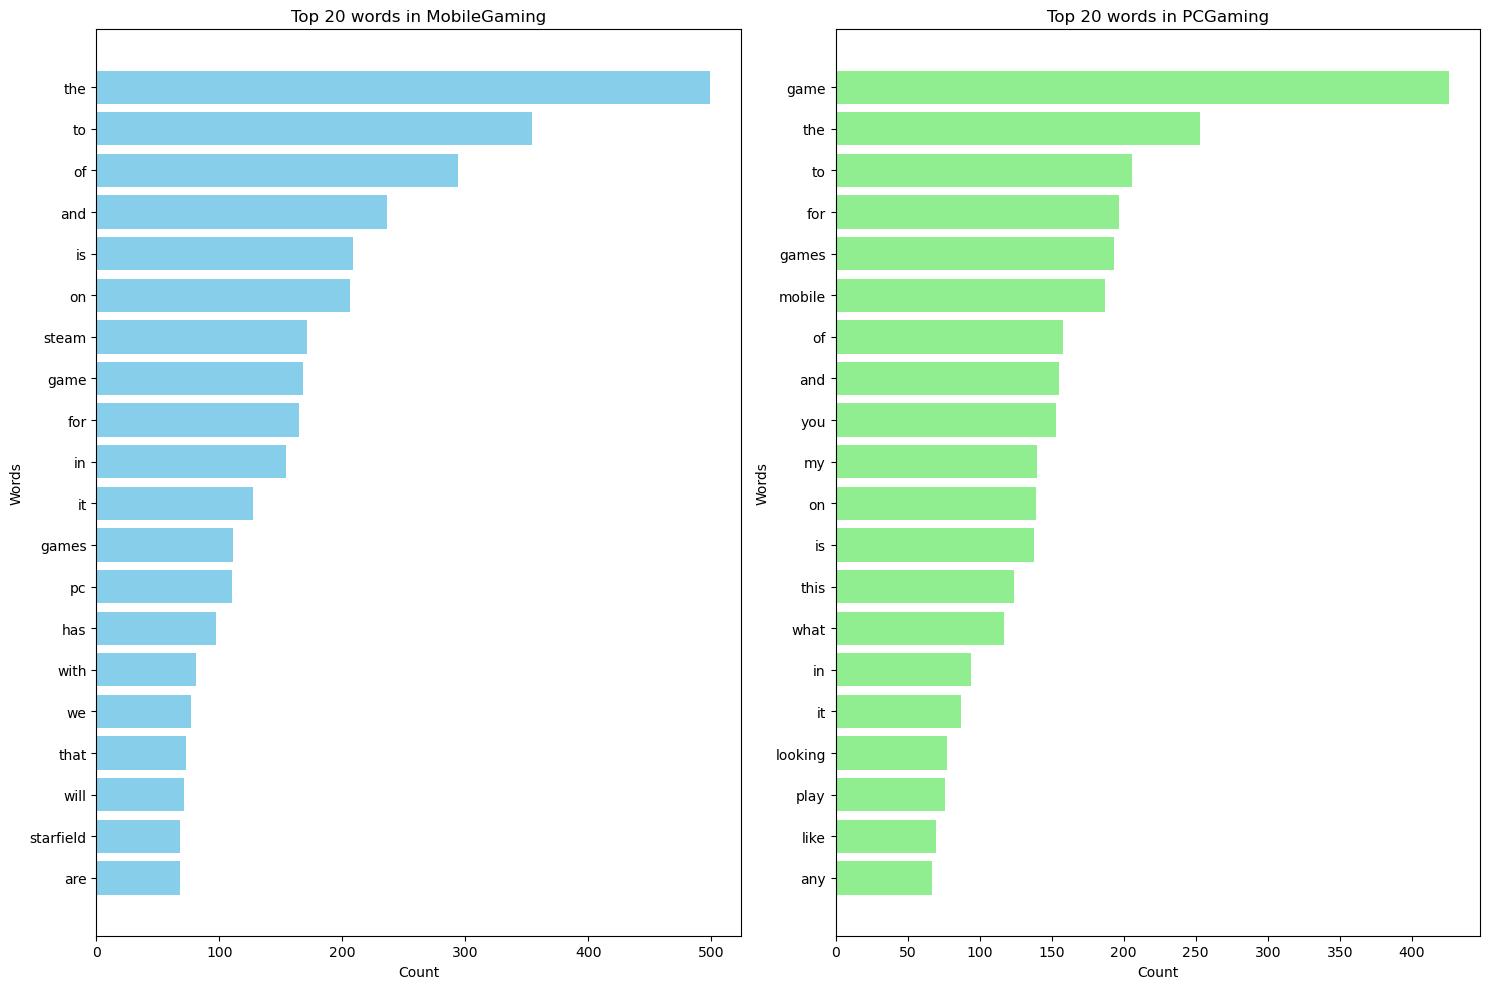

In [9]:
# Prepare the data for plotting
top_a_sorted_withoutStop = top_a_sorted_withoutStop[::-1]  
top_b_sorted_withoutStop = top_b_sorted_withoutStop[::-1] 

# Plotting
fig, axes = plt.subplots(ncols=2, figsize=(15, 10))

# MobileGaming Plot
axes[0].barh(top_a_sorted_withoutStop.index, top_a_sorted_withoutStop.values, color='skyblue')
axes[0].set_title('Top 20 words in MobileGaming')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Words')

# PCGaming Plot
axes[1].barh(top_b_sorted_withoutStop.index, top_b_sorted_withoutStop.values, color='lightgreen')
axes[1].set_title('Top 20 words in PCGaming')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

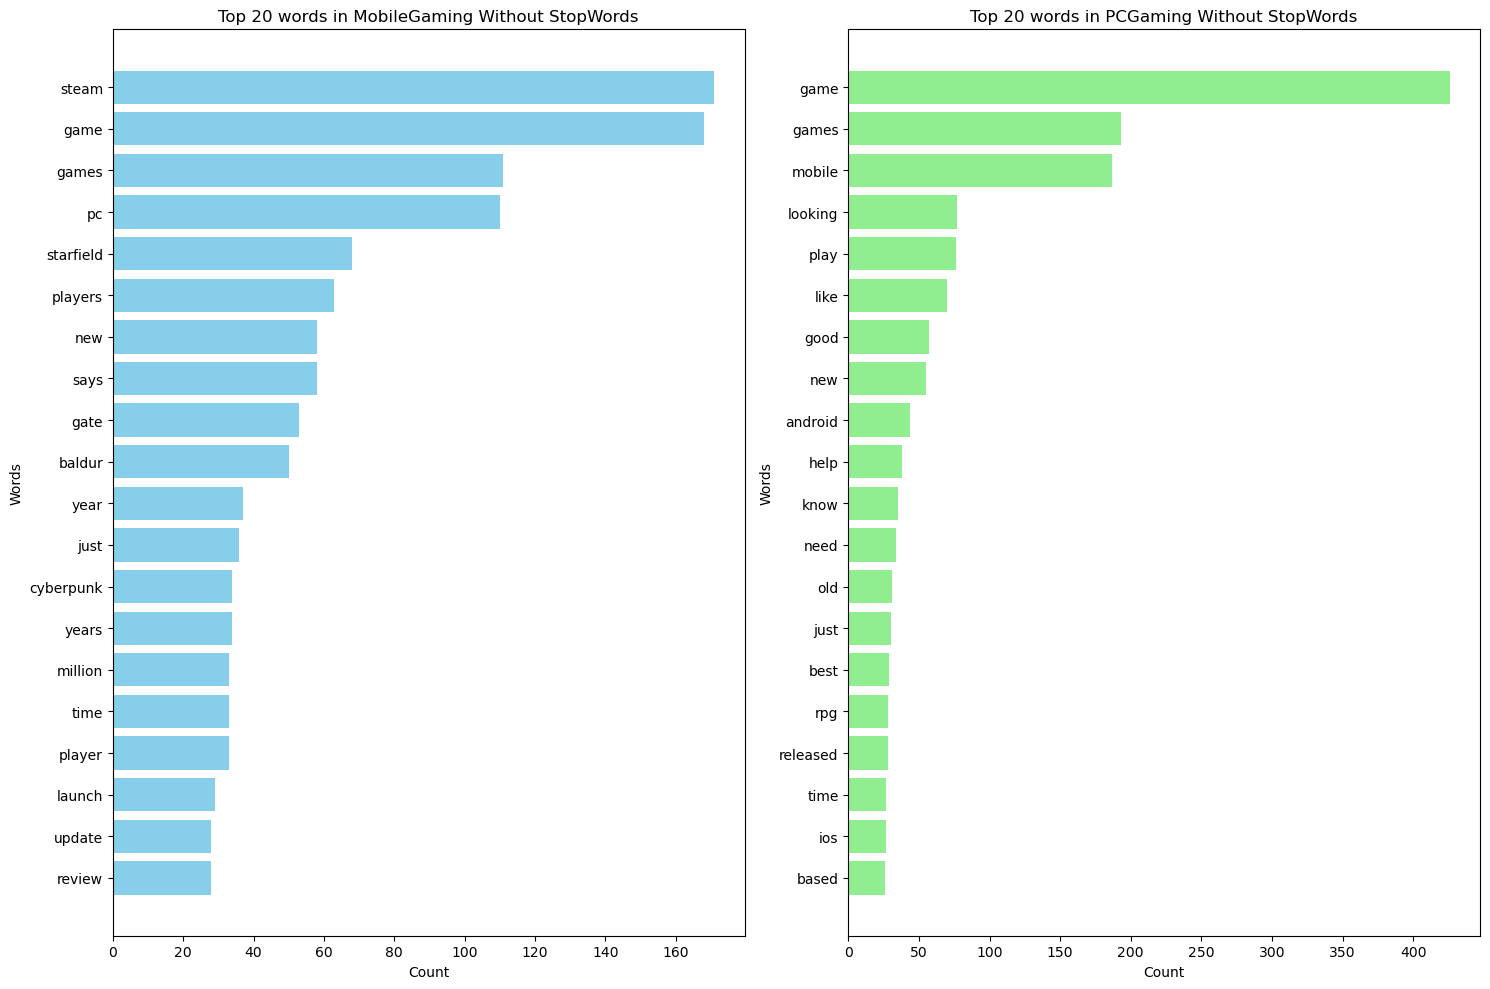

In [10]:
# Prepare the data for plotting
top_a_sorted = top_a_sorted[::-1]  
top_b_sorted = top_b_sorted[::-1] 

# Plotting
fig, axes = plt.subplots(ncols=2, figsize=(15, 10))

# MobileGaming Plot
axes[0].barh(top_a_sorted.index, top_a_sorted.values, color='skyblue')
axes[0].set_title('Top 20 words in MobileGaming Without StopWords')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Words')

# PCGaming Plot
axes[1].barh(top_b_sorted.index, top_b_sorted.values, color='lightgreen')
axes[1].set_title('Top 20 words in PCGaming Without StopWords')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

In [11]:
def plot_venn_diagram(words1, words2, title1, title2, title3, ax):
    # Convert the indices (words) of the Series to sets
    set1 = set(words1.index)
    set2 = set(words2.index)
    common_words = set1 & set2  # Find common words
    
    only_set1 = set1 - set2
    only_set2 = set2 - set1
    
    venn = venn2([set1, set2], set_labels=(title1, title2), ax=ax)
    venn2_circles([set1, set2], ax=ax)
    
    # Annotate common words in the Venn diagram
    common_words_text = "\n".join(sorted(common_words))
    if venn.get_label_by_id('11') is not None:
        venn.get_label_by_id('11').set_text(common_words_text)
        venn.get_label_by_id('11').set_fontsize(10)  # Adjust the font size if needed
    
    # Annotate words only in set1
    only_set1_text = "\n".join(sorted(only_set1))
    if venn.get_label_by_id('10') is not None:
        venn.get_label_by_id('10').set_text(only_set1_text)
        venn.get_label_by_id('10').set_fontsize(10)
    
    # Annotate words only in set2
    only_set2_text = "\n".join(sorted(only_set2))
    if venn.get_label_by_id('01') is not None:
        venn.get_label_by_id('01').set_text(only_set2_text)
        venn.get_label_by_id('01').set_fontsize(10)
    
    ax.set_title(title3)
    

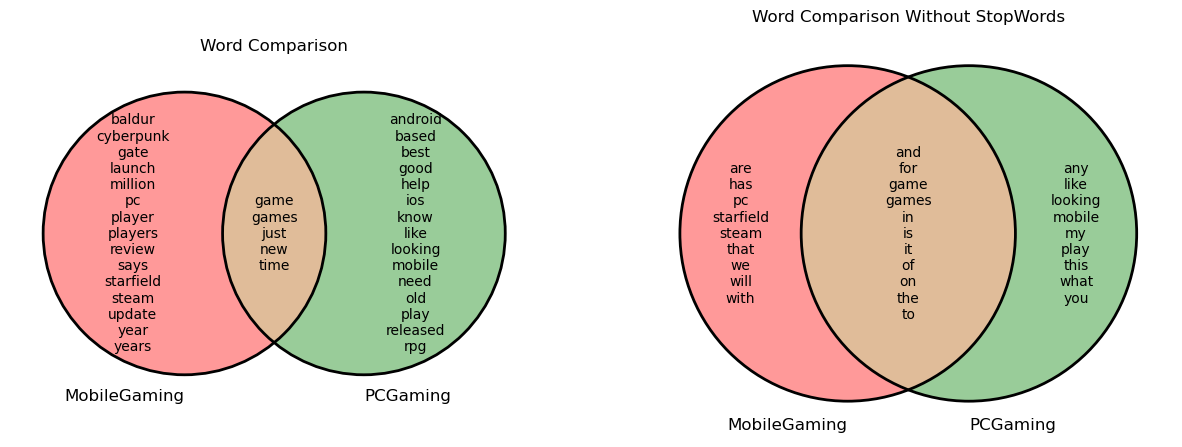

In [12]:
# Plot Venn Diagram
fig, axes = plt.subplots(ncols=2, figsize=(15, 10))
# Venn diagram for top words with stopwords removed
plot_venn_diagram(top_a_sorted, top_b_sorted, 'MobileGaming', 'PCGaming',"Word Comparison",axes[0])
# Venn diagram for top words without stopwords
plot_venn_diagram(top_a_sorted_withoutStop, top_b_sorted_withoutStop, 'MobileGaming', 'PCGaming', "Word Comparison Without StopWords", axes[1])


In [13]:
#get sentiment score and readability score 
analyzer = SentimentIntensityAnalyzer()
top_df1.loc[:, 'sentiment_title'] = top_df1['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
top_df1.loc[:, 'readability_title'] = top_df1['title'].apply(lambda x: textstat.flesch_reading_ease(x))

top_df2.loc[:, 'sentiment_title'] = top_df2['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
top_df2.loc[:, 'readability_title'] = top_df2['title'].apply(lambda x: textstat.flesch_reading_ease(x))

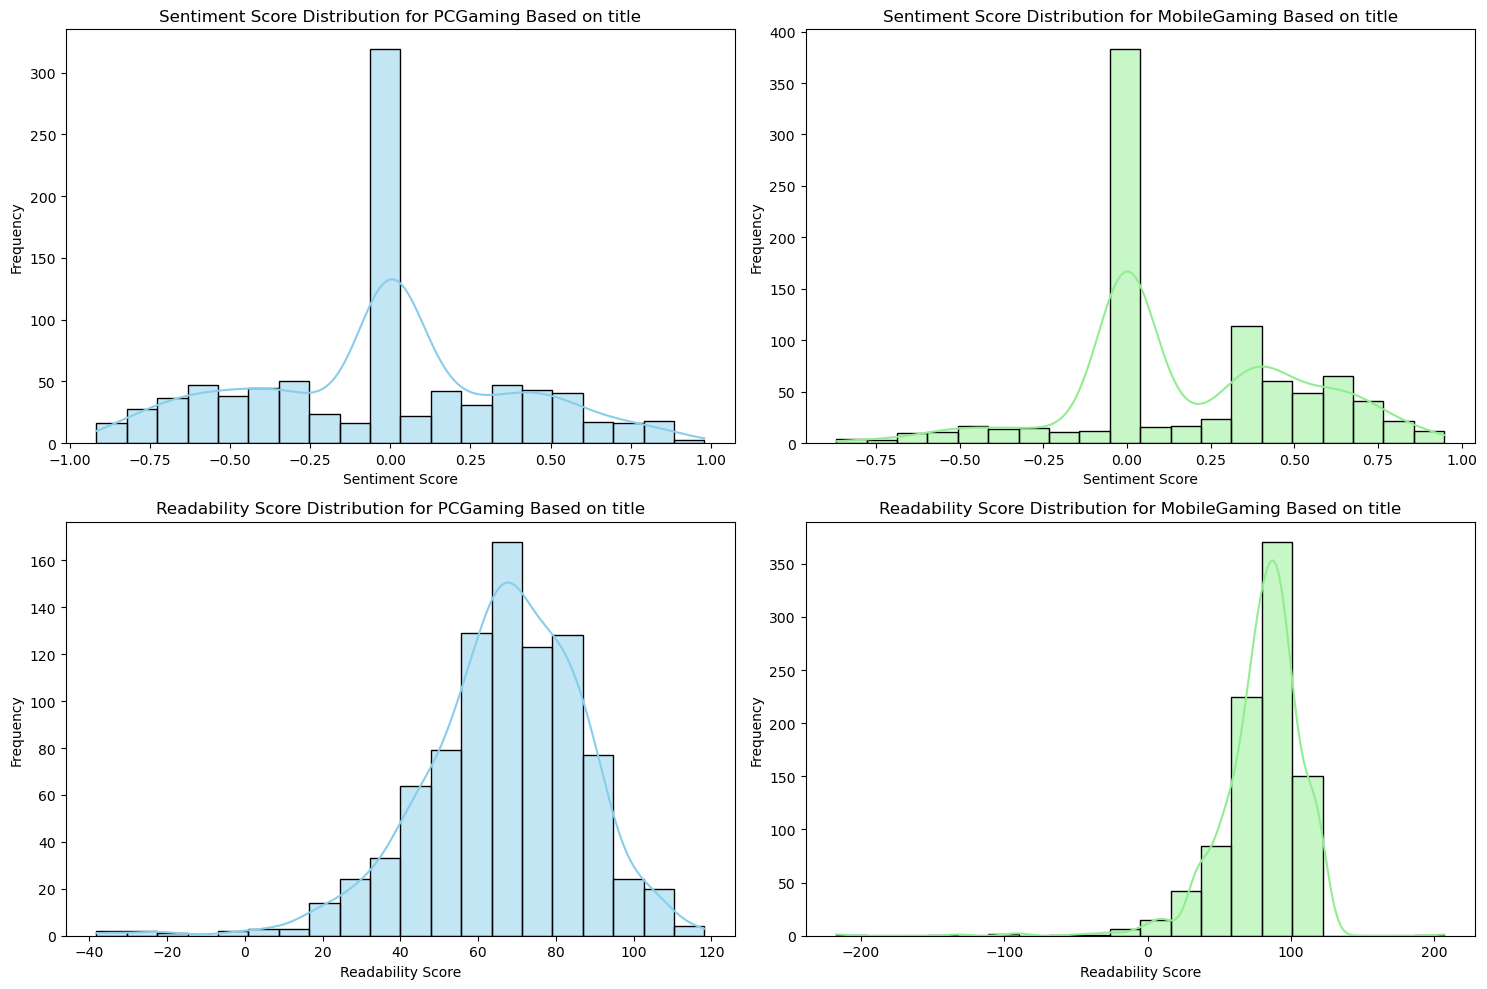

In [14]:
# Plot sentiment score distribution
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# Sentiment Score Distribution for PCGaming
sns.histplot(top_df1['sentiment_title'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Sentiment Score Distribution for PCGaming Based on title')
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Frequency')

# Sentiment Score Distribution for MobileGaming
sns.histplot(top_df2['sentiment_title'], bins=20, kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Sentiment Score Distribution for MobileGaming Based on title')
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Frequency')

# Readability Score Distribution for PCGaming
sns.histplot(top_df1['readability_title'], bins=20, kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Readability Score Distribution for PCGaming Based on title')
axes[1, 0].set_xlabel('Readability Score')
axes[1, 0].set_ylabel('Frequency')

# Readability Score Distribution for MobileGaming
sns.histplot(top_df2['readability_title'], bins=20, kde=True, ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Readability Score Distribution for MobileGaming Based on title')
axes[1, 1].set_xlabel('Readability Score')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## statistic

In [16]:
#combine the dataframes
combined_df = pd.concat([top_df1, top_df2])
sentiment_pc = top_df1['sentiment_title']
sentiment_mobile = top_df2['sentiment_title']

### Chi-Square Test

#### Null Hypothesis (H0):  there is no significant difference in the distribution of word frequencies between the two subreddits
### Alternative Hypothesis (H1): there is a significant difference in the distribution of word frequencies between the two subreddits

In [19]:
# Vectorize the titles
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(combined_df['title'])

# Create a DataFrame with word counts
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_counts['subreddit'] = combined_df['subreddit'].values

# Summarize word counts by subreddit
word_counts_summary = word_counts.groupby('subreddit').sum().T

# Perform the Chi-Square Test
chi2, p, dof, ex = chi2_contingency(word_counts_summary)
print(f'Chi-Square Statistic: {chi2}')
print(f'P-value: {p}')

Chi-Square Statistic: 8621.577768948217
P-value: 9.603111287063747e-300


### Mann-Whitney U Test 

### Null Hypothesis (H0): There is no significant difference in sentiment/readability scores between the two subreddits
### Alternative Hypothesis (H1): There is a significant difference in sentiment/readability scores between the two subreddits.

In [22]:
readability_pc = top_df1['readability_title']
readability_mobile = top_df1['readability_title']

# Mann-Whitney U Test for Sentiment Scores
model = mannwhitneyu(sentiment_pc, sentiment_mobile)
print('Mann-Whitney U Test for Sentiment Scores:')
print(model.pvalue)

Mann-Whitney U Test for Sentiment Scores:
2.9937340274256154e-29


In [23]:
# Mann-Whitney U Test for Readability Scores
model = mannwhitneyu(readability_pc, readability_mobile)
print('Mann-Whitney U Test for Readability Scores:')
print(model.pvalue)

Mann-Whitney U Test for Readability Scores:
1.0


## ML

In [25]:
#Prepare data and create features.
# Combine dataframes
df_a = top_df1.copy()
df_b = top_df2.copy()
df = pd.concat([df_a, df_b]).reset_index(drop=True)

# encoding the data
df['subreddit_encode'] = df['subreddit'].map({'pcgaming': 0, 'MobileGaming': 1})


## LogisticRegression

In [83]:
# Fit and transform the combined data using CountVectorizer and does not used stop_words
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer(stop_words='english')

X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Train logistic regression model
lr_model_1 = LogisticRegression()
lr_model_1.fit(X_train_cv, y_train)

# Evaluate model
score = lr_model_1.score(X_test_cv, y_test)
print('Model without stop words removal score:', score)
print(classification_report(y_test, lr_model_1.predict(X_test_cv)))

Model without stop words removal score: 0.9111111111111111
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       270
           1       0.87      0.97      0.92       270

    accuracy                           0.91       540
   macro avg       0.92      0.91      0.91       540
weighted avg       0.92      0.91      0.91       540



In [85]:
# Fit and transform the combined data using CountVectorizer and included stop_words
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer()

X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Train logistic regression model
lr_model_1 = LogisticRegression()
lr_model_1.fit(X_train_cv, y_train)

# Evaluate model
score = lr_model_1.score(X_test_cv, y_test)
print('Model with stop words removal score:', score)
print(classification_report(y_test, lr_model_1.predict(X_test_cv)))


Model with stop words removal score: 0.924074074074074
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       270
           1       0.91      0.94      0.93       270

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540



In [29]:
##sentiment score 
X_sentiment = df[['sentiment_title']]
y = df['subreddit_encode'].values

# Split the data
X_train_sentiment, X_test_sentiment, y_train, y_test = train_test_split(X_sentiment, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model_sentiment = LogisticRegression()
model_sentiment.fit(X_train_sentiment, y_train)

# Predict and evaluate
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
print('Sentiment Score Only - Accuracy:', accuracy_score(y_test, y_pred_sentiment))
print(classification_report(y_test, y_pred_sentiment))

Sentiment Score Only - Accuracy: 0.5944444444444444
              precision    recall  f1-score   support

           0       0.57      0.72      0.64       267
           1       0.63      0.47      0.54       273

    accuracy                           0.59       540
   macro avg       0.60      0.60      0.59       540
weighted avg       0.60      0.59      0.59       540



In [30]:
## readability score
X_readability = df[['readability_title']]
y = df['subreddit_encode'].values

# Split the data
X_train_readability, X_test_readability, y_train, y_test = train_test_split(X_readability, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model_readability = LogisticRegression()
model_readability.fit(X_train_readability, y_train)

# Predict and evaluate
y_pred_readability = model_readability.predict(X_test_readability)
print('Readability Score Only - Accuracy:', accuracy_score(y_test, y_pred_readability))
print(classification_report(y_test, y_pred_readability))

Readability Score Only - Accuracy: 0.6537037037037037
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       267
           1       0.65      0.70      0.67       273

    accuracy                           0.65       540
   macro avg       0.65      0.65      0.65       540
weighted avg       0.65      0.65      0.65       540



## Random Forest model

In [32]:
# Define features and target
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer(stop_words='english')
X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=45)
rf_model.fit(X_train_cv, y_train)

# Evaluate model
score = rf_model.score(X_test_cv, y_test)
print('Model with stop words removal score and Random Forest score:', score)
print(classification_report(y_test, rf_model.predict(X_test_cv)))




Model with stop words removal score and Random Forest score: 0.8537037037037037
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       270
           1       0.78      0.99      0.87       270

    accuracy                           0.85       540
   macro avg       0.88      0.85      0.85       540
weighted avg       0.88      0.85      0.85       540



In [79]:
# Define features and target
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer()
X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=45)
rf_model.fit(X_train_cv, y_train)

# Evaluate model
score = rf_model.score(X_test_cv, y_test)
print('Model with stop words removal score and Random Forest score:', score)
print(classification_report(y_test, rf_model.predict(X_test_cv)))


Model with stop words removal score and Random Forest score: 0.8796296296296297
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       270
           1       0.83      0.95      0.89       270

    accuracy                           0.88       540
   macro avg       0.89      0.88      0.88       540
weighted avg       0.89      0.88      0.88       540



In [81]:
#for sentiment score
X_sentiment = df[['sentiment_title']]
y = df['subreddit_encode'].values

# Split the data
X_train_sentiment, X_test_sentiment, y_train, y_test = train_test_split(X_sentiment, y, test_size=0.3, random_state=42)

# Train the Random Forest model
model_sentiment_rf = RandomForestClassifier(random_state=42)
model_sentiment_rf.fit(X_train_sentiment, y_train)

# Predict and evaluate
y_pred_sentiment_rf = model_sentiment_rf.predict(X_test_sentiment)
print('Sentiment Score Only – Random Forest – Accuracy:', accuracy_score(y_test, y_pred_sentiment_rf))
print(classification_report(y_test, y_pred_sentiment_rf))

Sentiment Score Only – Random Forest – Accuracy: 0.6351851851851852
              precision    recall  f1-score   support

           0       0.70      0.46      0.56       267
           1       0.60      0.80      0.69       273

    accuracy                           0.64       540
   macro avg       0.65      0.63      0.62       540
weighted avg       0.65      0.64      0.62       540



In [34]:
## readability score
X_readability = df[['readability_title']]
y = df['subreddit_encode'].values

# Split the data
X_train_readability, X_test_readability, y_train, y_test = train_test_split(X_readability, y, test_size=0.3, random_state=42)

model_readability_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_readability_rf.fit(X_train_readability, y_train)

# Predict and evaluate
y_pred_readability_rf = model_readability_rf.predict(X_test_readability)
print('Readability Score Only - Random Forest - Accuracy:', accuracy_score(y_test, y_pred_readability_rf))
print(classification_report(y_test, y_pred_readability_rf))

Readability Score Only - Random Forest - Accuracy: 0.6796296296296296
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       267
           1       0.70      0.65      0.67       273

    accuracy                           0.68       540
   macro avg       0.68      0.68      0.68       540
weighted avg       0.68      0.68      0.68       540



## MultinomialNB

In [75]:
#without stopwords
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer(stop_words='english')

X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cv)
X_test_scaled = scaler.fit_transform(X_test_cv)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_scaled, y_train)

score = nb_model.score(X_test_scaled, y_test)
print('Model with stop words removal score and Naive Bayes score:', score)

Model with stop words removal score and Naive Bayes score: 0.9259259259259259


In [73]:
#with stopwords
X = df['title']
y = df['subreddit_encode'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=3050)

# Fit and transform the combined data using CountVectorizer
cvec = CountVectorizer()
X_train_cv = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names_out())

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cv)
X_test_scaled = scaler.fit_transform(X_test_cv)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_scaled, y_train)

score = nb_model.score(X_test_scaled, y_test)
print('Model with stop words removal score and Naive Bayes score:', score)

Model with stop words removal score and Naive Bayes score: 0.9333333333333333


### Got an error: cannot use 'sentiment_title' or 'readability_title' data to respectivly to predict the subreddit by using multinomialNB 
### sentiment_title or readability_title individually might not provide sufficient discriminatory power for the classifier because it could be too simplistic to capture the complexities of the subreddit content. 

In [39]:
X_combined = df[['sentiment_title', 'readability_title']]
y = df['subreddit_encode'].values

X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

scaler_combined = MinMaxScaler()
X_train_combined_scaled = scaler_combined.fit_transform(X_train_combined)
X_test_combined_scaled = scaler_combined.transform(X_test_combined)

model_combined = MultinomialNB()
model_combined.fit(X_train_combined_scaled, y_train)

y_pred_combined = model_combined.predict(X_test_combined_scaled)
print('Combined Features - Accuracy:', model_combined.score(X_test_combined_scaled, y_test))
print(classification_report(y_test, y_pred_combined))

Combined Features - Accuracy: 0.5981481481481481
              precision    recall  f1-score   support

           0       0.57      0.79      0.66       267
           1       0.67      0.41      0.51       273

    accuracy                           0.60       540
   macro avg       0.62      0.60      0.58       540
weighted avg       0.62      0.60      0.58       540

